<a href="https://colab.research.google.com/github/igoravelli/brazilian_soccer_championship_analysis/blob/main/Events_frequency_along_the_turns_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install pandasql

import pandas as pd
import sqlite3
import numpy as np
import seaborn as sns
import sys

from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table
from matplotlib import pyplot as plt

data_table.enable_dataframe_formatter()
auth.authenticate_user()


project = 'brasileirao-362523'
schema = '3_gold'
location = 'US'

client = bigquery.Client(project=project, location=location)

# Extract data

In [2]:
# @title Get dimMatch data
dim_match = client.query(f"""
      SELECT * FROM `{project}.{schema}.dimMatch`
    """).to_dataframe()

dim_match.set_index('pk_match', inplace=True)
dim_match.head()

,stadium,away_team,home_team,round,match_date,championship_year,home_team_squad,away_team_squad,winner,loser
pk_match,,,,,,,,,,
1114,mane_garrincha,vasco,brasiliense,1,2005-04-24 18:10:00,2005,N/A,N/A,None,None
1148,boca_do_jacare,fluminense,brasiliense,4,2005-05-15 18:10:00,2005,N/A,N/A,fluminense,brasiliense
1167,boca_do_jacare,parana,brasiliense,6,2005-05-29 16:00:00,2005,N/A,N/A,brasiliense,parana
1183,mane_garrincha,corinthians,brasiliense,8,2005-06-18 16:00:00,2005,N/A,N/A,corinthians,brasiliense
1213,boca_do_jacare,athletico-pr,brasiliense,10,2005-07-03 18:10:00,2005,N/A,N/A,brasiliense,athletico-pr


In [3]:
# @title Get factEvents data
ft_events = client.query(f"""
      SELECT * FROM `{project}.{schema}.factEvents`
    """).to_dataframe()

ft_events.set_index('pk_fact_event', inplace=True)
ft_events.head()

,fk_match_id,fk_team_id,fk_calendar_id,fk_player_id,fk_stadium_id,event,minute,extra_time
pk_fact_event,,,,,,,,
2000001,4607,1268,20140419,14367,100104,goal,31,0
2000002,4607,1231,20140419,15053,100104,yellow,44,0
2000003,4607,1268,20140419,11742,100104,goal,45,0
2000004,4607,1268,20140419,14030,100104,goal,59,0
2000005,4607,1231,20140419,14206,100104,yellow,66,0


In [4]:
# @title Join dimPartida, factEventos
df_analysis = ft_events.merge(dim_match, left_on='fk_match_id', right_on='pk_match', how='inner')

df_analysis = df_analysis[["event","round","championship_year"]]

# df_analysis = df_analysis.sort_values(['fk_id_partida'])

df_analysis.head()

,event,round,championship_year
0,goal,1,2014
1,yellow,1,2014
2,goal,1,2014
3,goal,1,2014
4,yellow,1,2014


# Transformations

In [5]:
# @title Create segmentation by turns
c1 = np.logical_and(df_analysis['round'].to_numpy() >= 1, df_analysis['round'].to_numpy() <= 19)
c2 = np.logical_and(df_analysis['round'].to_numpy() >= 20, df_analysis['round'].to_numpy() <= 38)

condlist = [c1,c2]
choicelist = [1,2]

df_analysis['turn'] = np.select(condlist, choicelist)

df_analysis['turn'] = df_analysis.apply(lambda x: '%s-%s' % (x['championship_year'],x['turn']), axis=1)

df_analysis.head()



,event,round,championship_year,turn
0,goal,1,2014,2014-1
1,yellow,1,2014,2014-1
2,goal,1,2014,2014-1
3,goal,1,2014,2014-1
4,yellow,1,2014,2014-1


In [9]:
# @title Group events by 'year-turn'
df_aux = df_analysis.groupby(['turn','event']).agg({'event':['count']})

df_aux = df_aux[('event','count')].reset_index()

df_aux = df_aux.pivot(index=[('turn','')], columns=[( 'event','')], values=[('event', 'count')])

df_aux.columns = df_aux.columns.get_level_values(1)

df_aux = df_aux.reset_index()

df_aux.columns = ['Turn', 'Goals', 'Red Cards', 'Yellow Cards']

df_aux.head()

,Turn,Goals,Red Cards,Yellow Cards
0,2014-1,399,38,871
1,2014-2,461,44,821
2,2015-1,421,54,932
3,2015-2,476,55,952
4,2016-1,486,44,886


Text(0, 0.5, '# of Events')

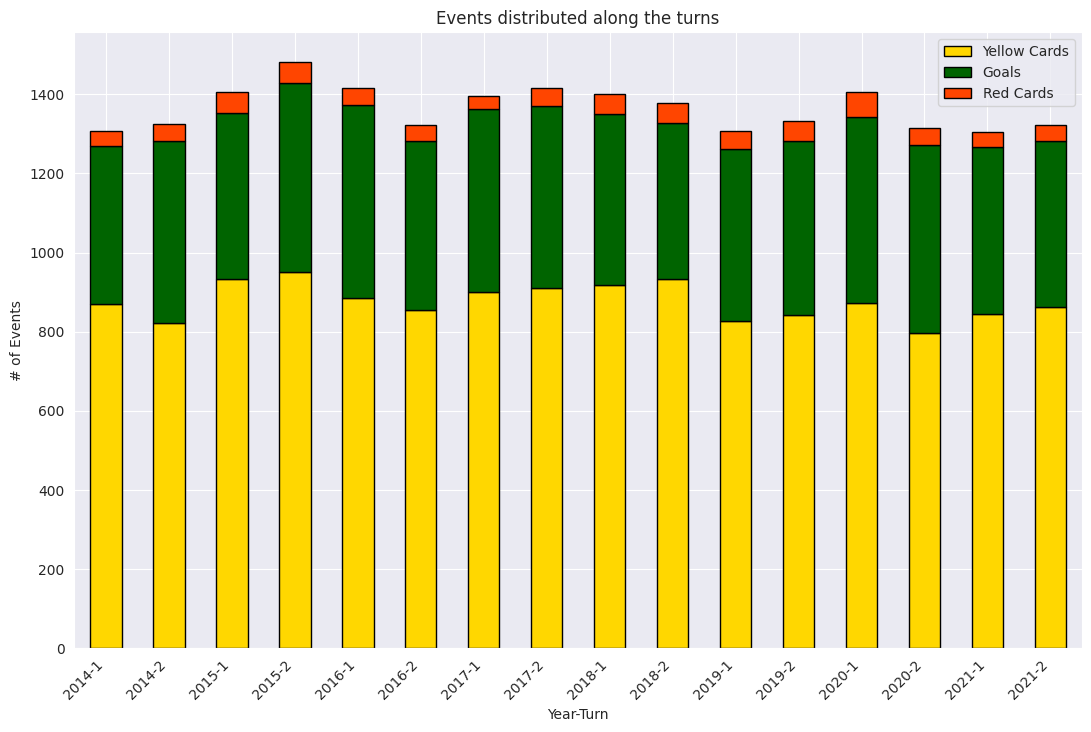

In [10]:
# @title Plot chart
plt.rcParams["figure.figsize"] = [13, 8]
sns.set_style("darkgrid")
df_aux.plot(x='Turn', y=['Yellow Cards', 'Goals', 'Red Cards'], kind="bar", color = ['#FFD700','#006400','#FF4500'], stacked=True, edgecolor = "black", linewidth = 1)

plt.xticks(rotation=45, ha='right')
plt.title("Events distributed along the turns")
plt.xlabel("Year-Turn")
plt.ylabel("# of Events")

# Conclusion

The brazilian soccer championship (known as "Brasileirão") is a competition in which the teams play against every other participant twice (double round-robin system). There are 38 rounds divided into 2 turns, once at home stadium and once at their opponents stadium. So, the aim of this analysis was to understand if the events (goals, yellow cards and red cards) were more often at the first turn or at the second one.

As a conclusion, the chart above shows us that there is not a clear tendency about the events in each half. Even if we analyse the sum of events or each one
separately. A hypothesys could be about the balance between the quality´s team, and therefore the balance in the matches. It is interesting to highlight that in "Brasileirão" is common to start the season with 5 or 6 favorite clubs  to win the league.